In [85]:
from pylab import *
from scipy.ndimage import filters,measurements
from scipy import stats

Let's start with a "trivial" edge detector: this just finds all the pixels where local differences are above a threshold.

In [45]:
def trivedges(m,threshold=1e-3):
    return abs(m-roll(m,1,0))+abs(m-roll(m,1,1))>threshold

# Mondrian World

Generate a "Mondrian world" image.

In [101]:
def mondrian(dims=(200,200),sr=(20,50),n=100,noise=0.5):
    h,w = dims
    image = zeros(dims)
    for i in range(n):
        y = randint(h)
        x = randint(w)
        ry = randint(*sr)
        rx = randint(*sr)
        y0 = clip(y-ry,0,h)
        y1 = clip(y+ry,0,h)
        x0 = clip(x-rx,0,w)
        x1 = clip(x+rx,0,w)
        image[y0:y1,x0:x1] = rand()
    edges = trivedges(image)
    return image+noise*randn(*image.shape),edges

The `mondrian` function returns both a noisy image and an edge map.

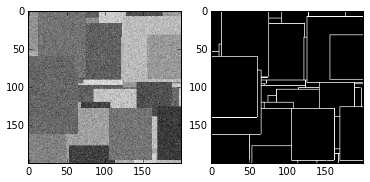

In [110]:
image,edges = mondrian(noise=0.1)
subplot(121); imshow(image,cmap=cm.gray)
subplot(122); imshow(edges,cmap=cm.gray)

Trivial edge detection applied to the noisy image results in rather noisy output.

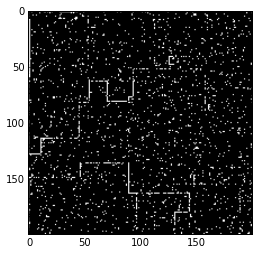

In [112]:
imshow(trivedges(m,threshold=0.5),cmap=cm.gray)

# F-Measure Evaluation

Evaluation of an edge detector can be done by the _f-measure_.
This computes the fraction of returned edge pixesl that are correct (precision)
and the fraction of all true edge pixels that are returned (recall).
The harmonic mean of these two is called the _f-measure_.



In [113]:
def evaluate_edges(truth,pred,b=5):
    cases = array(2*(truth!=0)+(pred!=0),'i')[b:-b,b:-b]
    c00,c01,c10,c11 = measurements.sum(ones(cases.shape),cases,arange(4))
    precision = c11 * 1.0 / (c01 + c11)
    recall = c11 * 1.0 / (c10 + c11)
    fmeasure = precision * recall / (precision + recall)
    return fmeasure,precision,recall



In [114]:
evaluate_edges(edges,trivedges(m,threshold=0.2))

(0.046415529502210263, 0.051003167898627244, 0.51602564102564108)

We can now try to find the optimal edge detection parameters.



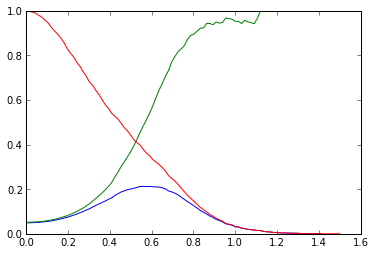

In [117]:
es = []
ts = linspace(0.0,1.5,100)
for threshold in ts:
    e = evaluate_edges(edges,trivedges(image,threshold=threshold))
    es.append(e)
es = array(es)
plot(ts,es[:,0])
plot(ts,es[:,1])
plot(ts,es[:,2])

# Blobworld

Here is a second model image generator.



In [127]:
def blobworld(dims=(200,200),sigma=10.0,frac=0.5,noise=0.5):
    h,w = dims
    image = randn(*dims)
    image = filters.gaussian_filter(image,sigma)
    threshold = stats.scoreatpercentile(image,frac*100)
    image = (image>threshold)
    image,n = measurements.label(image)
    image = rand(n+1)[image]
    edges = trivedges(image)
    return image+noise*randn(*image.shape),edges

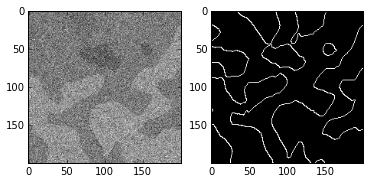

In [128]:
bw,be = blobworld()
subplot(121); imshow(bw,cmap=cm.gray)
subplot(122); imshow(be,cmap=cm.gray)

# Homework

(1) Construct an edge detector by applying a smoothing filter followed by a `trivedges`-style derivative and appropriate thresholding. For smoothing filters, try at least `uniform_filter` and `gaussian_filter`. For the given default noise levels in `mondrian` and `blobworld`, find the optimal parameters for both filters in terms of f-measure by exploring the parameter space. To do this, generate a fixed list of test cases, perform edge detection with different parameters, and evaluate the f-measure for all of them and average the f-measure (additional question: is averaging the right thing to combine f-measures?).

(2) Add hysteresis thresholding to the edge detector and try different hysteresis thresholding parameters; can you improve the f-measure?